# Linear SVM, CSAR trining, Docking Scores, Pisani Residues

>

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

In [2]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Helper function
%run ./helper_functions_S6.ipynb

In [4]:
# Loading the data:
data_dir = '../data/docking_scores/'
# vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = \
open_results(path = F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', 
             column_to_drop = 'ActiveInactive')
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DUD, y_dksc_DUD = \
open_results(path = F'{data_dir}/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
             column_to_drop = 'Actividad')
# Vianrdo Docking Scores (dksc) DEKOIS2
X_dksc_DEKOIS, y_dksc_DEKOIS = \
open_results(path = F'{data_dir}/vs_dk_CRYS_402_DEKOIS_VINARDO_docking_score.csv',
             column_to_drop = 'Actividad')

In [5]:
# Dictionary of docking results (Only DkSc are included)
scores_dic = {'CSAR': {'Dk_sc':   {'X': X_dksc_CSAR, 'y': y_dksc_CSAR}}, 
              'DUD':  {'Dk_sc':   {'X': X_dksc_DUD,  'y': y_dksc_DUD}}, 
              'DEKOIS': {'Dk_sc': {'X': X_dksc_DEKOIS,  'y': y_dksc_DEKOIS}}, 
             }

In [6]:
# Testing with the two following estimators
from sklearn.svm import SVC, LinearSVC

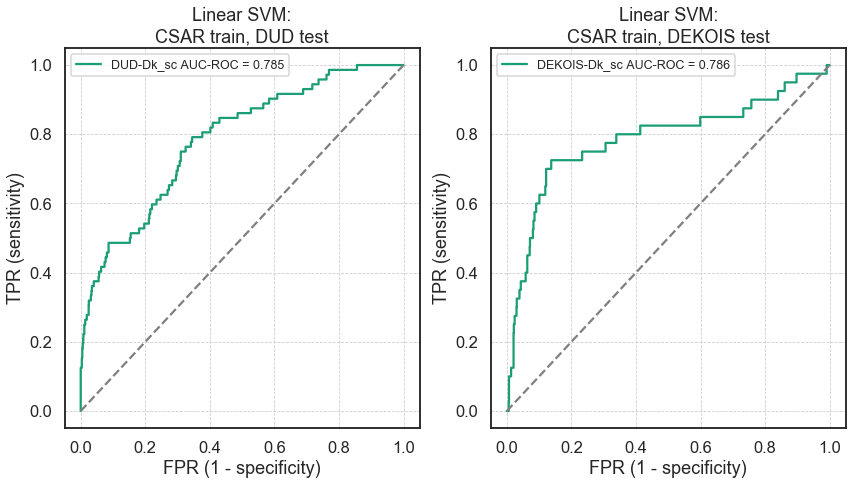

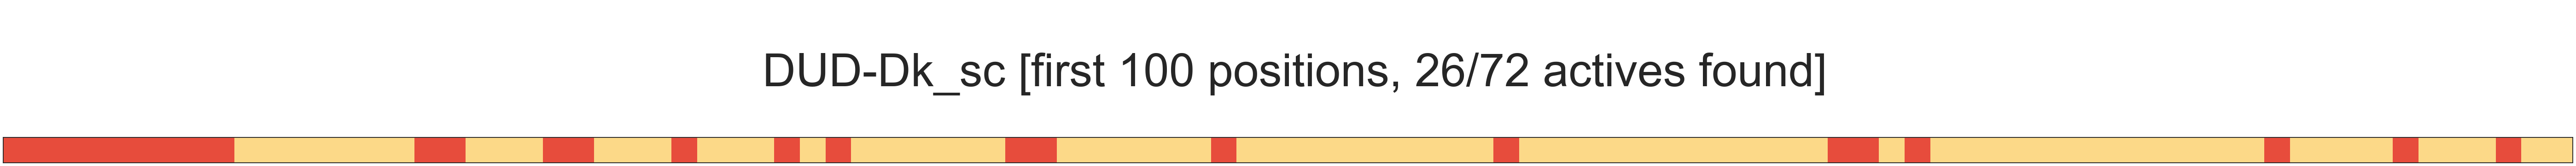

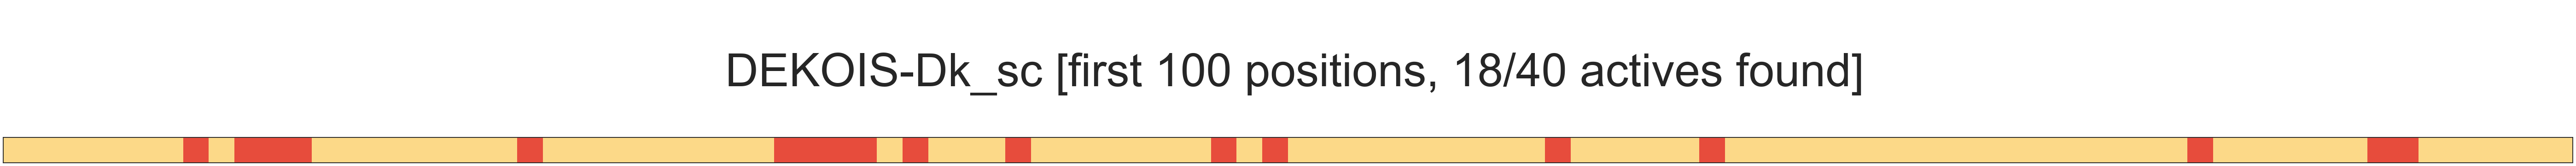

In [7]:
# first with SVC
# The best param found in the  grid search was C = 1
score_type = 'Dk_sc'
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
C = 0.1
model = SVC


svm = SVC
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = [score_type],
                               scores_dic = scores_dic, estimator = svm,
                               kernel = 'linear', probability = True, C = 0.1 )

svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = [score_type], 
                            scores_dic = scores_dic, decreasing = False)

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)


## Random Sampling:
Randomly choose n features for train and test.

In [8]:
import os
# Files to save the results
dud_file_rd = '../data/ml_evaluations/\
RANDOM_sampling_1_to_402_features_CSAR_train_DUD_test.json'
dekois_file_rd = '../data/ml_evaluations/\
RANDOM_sampling_1_to_402_features_CSAR_train_DEKOIS_test.json'

In [9]:
%%time

if not os.path.isfile(dud_file_rd):
    # Defining some variables and parameters
    score_type = 'Dk_sc'
    train_key = 'CSAR'
    test_keys = ['DUD', 'DEKOIS']
    C = 0.1
    model = SVC
    # Random picking parameters
    N_REPS = 50
    MIN_CONFS = 1
    MAX_CONFS = 402
    INTERVAL = 1

    # Then we create the dataframes to store the results
    list_of_columns = [F'rep_{i}' for i in range(N_REPS)]

    # Two dataframes, one for DUD and one for DEKOIS
    df_rdPick_DUD_lsvc = pd.DataFrame(columns = list_of_columns)
    df_rdPick_DEKOIS_lsvc = pd.DataFrame(columns = list_of_columns)


    # Run the loop
    for N_CONFS in range(MIN_CONFS, MAX_CONFS + 1, INTERVAL):
        if N_CONFS%(10) == 0:
             print(F'Iteración: {N_CONFS}')
        n_conf_row = random_confs_picking(scores_dic = scores_dic, score_type = score_type,
                                 train_key = train_key, test_keys = test_keys,
                                 n_features = N_CONFS, n_reps = N_REPS,
                                 # Exclusive hyperparameters for the selected model
                                 model = model, C = C, kernel = 'linear', probability = True)
        # Add the result to the corresponding row
        df_rdPick_DUD_lsvc.loc[ N_CONFS ] = n_conf_row['DUD']
        df_rdPick_DEKOIS_lsvc.loc[ N_CONFS ] = n_conf_row['DEKOIS']

CPU times: user 46 µs, sys: 10 µs, total: 56 µs
Wall time: 65.1 µs


In [10]:
# Save the results
if os.path.isfile(dud_file_rd):
    df_rdPick_DUD_lsvc = pd.read_json(dud_file_rd)
else:
    df_rdPick_DUD_lsvc.to_json()

if os.path.isfile(dekois_file_rd):
    df_rdPick_DEKOIS_lsvc = pd.read_json(dekois_file_rd)
else:
    df_rdPick_DEKOIS_lsvc.to_json()

### Plotting the results

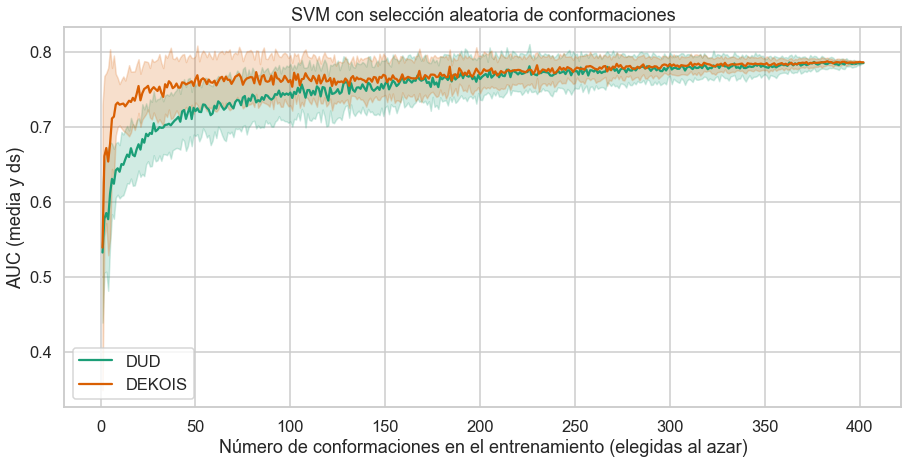

In [11]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DUD_lsvc.T.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DEKOIS_lsvc.T.melt(), ci = 'sd', label = 'DEKOIS')
plt.xlabel('Número de conformaciones en el entrenamiento (elegidas al azar)')
plt.ylabel('AUC (media y ds)')
plt.title('SVM con selección aleatoria de conformaciones')
plt.show()

## K-means clustering

In [12]:
# Read the MDS resuts
import pickle
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
#
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

#### Performs the k-means clustering

In [13]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import viridis
output_notebook()

Loading BokehJS ...

In [14]:
# Kmeans over the first two dimensions
fd = 2
_X = mds_pisani_402[0][:fd].T

n_clusters = 20
kmc = KMeans(n_clusters = n_clusters, random_state = 0)
kmc.fit( _X )

# Create the datasource
data_mds = ColumnDataSource({
    'x': _X.T[0],
    'y': _X.T[1],
    'cluster': kmc.labels_.astype('str')
})
CLUSTERS = np.unique(kmc.labels_.astype('str'))
color_map = factor_cmap('cluster', palette= viridis(len(CLUSTERS)), factors = CLUSTERS)

# Create the colors

f = figure(title = F'K-Means clustering (k = {n_clusters})', active_scroll='wheel_zoom')
# Plot the reference space
f.circle('x', 'y', color = color_map, source = data_mds, size = 6)

# Plot the centroids
f.triangle(x = kmc.cluster_centers_[:,0], 
           y = kmc.cluster_centers_[:,1], color = (220,20,60, 0.5), size = 10,
          line_color = 'black', legend_label = 'Centroids')
# Plot the medoids
medoids_idx = get_medoids_idx(mds_pisani_402[0], n_dims = fd, n_clusters = n_clusters,
                             random_state = 0)
_X_medoids = _X[ medoids_idx, :]
# Plot medoids
f.circle(x = _X_medoids.T[0], 
           y = _X_medoids.T[1], color = (255, 241, 116, 0), size = 10,
          line_color = 'black',  legend_label = 'Medoids')

show(f)

#### Elbow method using cluster inertia

In [15]:
K = 50
distortions = np.zeros(K)

for k in range(K):
    kmc = KMeans(n_clusters = k + 1, random_state = 0)
    kmc.fit(_X)
    distortions[k] = kmc.inertia_

In [16]:
f_2 = figure(title='Elbow method for kmeans clustering', plot_width = 900, plot_height = 300)
f_2.line(x = range(1, K+1), y = distortions)
f_2.circle(x = range(1, K+1), y = distortions)
f_2.xaxis.axis_label = 'k clusters'
f_2.yaxis.axis_label = 'Distortion'
show(f_2)

In [17]:
%%time

score_type = 'Dk_sc'
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
C = 0.1
model = SVC
model_extra_params = dict(kernel = 'linear', probability = True, C = 0.1)
metric = 'roc_auc'

MAX_N_CONFS = 402

# Creates the dictionary of results to be filled and returned
# Saving to pandas dataframe
output_dir = '../data/ml_evaluations/'
file_name_kmeans = F'{output_dir}/KMEANS_sampling_1_to_402_features_CSAR_train_DUD_DKOIS_test_pisani_MDS'

if os.path.isfile(file_name_kmeans):
    # Load the file
    df_kmeans_results = pd.read_json(file_name_kmeans)
else: # Run the code and save the file
    results_dict = {}
    for test in test_keys:
        results_dict[test] = np.zeros(MAX_N_CONFS)


    for i in range(MAX_N_CONFS):
        # Selection of k conformations using K-Means
        k = i + 1
        medoids_idx = get_medoids_idx(mds_pisani_402[0], n_dims = fd, n_clusters = k,
                                     random_state = 0)
        features = scores_dic[train_key][score_type]['X'].columns[medoids_idx]

        # Performs the LinearSVC
        model_train = train_wrapper(train_key = train_key, list_of_scores = [score_type],
                                    scores_dic = scores_dic, estimator = model,
                                    selected_features= features,
                                    **model_extra_params)

        model_pred = eval_wrapper(trained_model = model_train, 
                                    test_keys = test_keys, list_of_scores = [score_type], 
                                    selected_features= features,
                                    scores_dic = scores_dic, decreasing = False)

        for test in test_keys:
                metric_value = model_pred[test].format_metric_results(metric).values[0][0]
                results_dict[test][i] = metric_value

    df_kmeans_results = pd.DataFrame(results_dict)
    df_kmeans_results.to_json(file_name_kmeans)

CPU times: user 4.9 ms, sys: 3.66 ms, total: 8.56 ms
Wall time: 6.98 ms


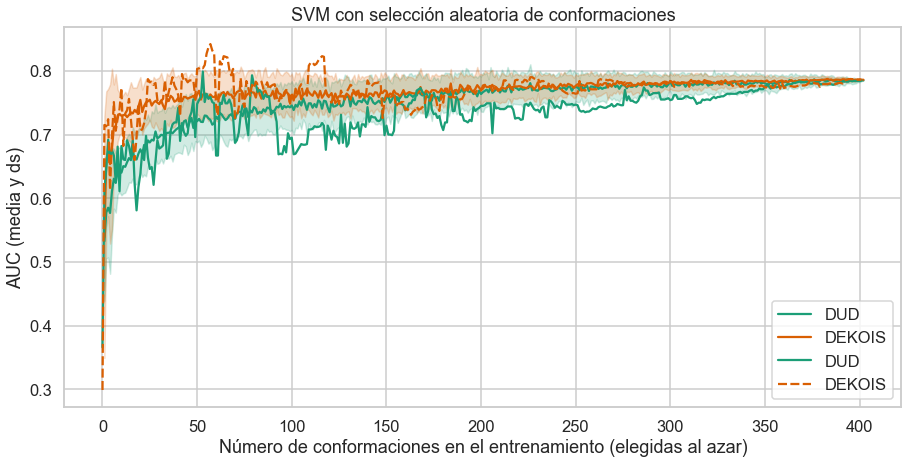

In [19]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DUD_lsvc.T.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_rdPick_DEKOIS_lsvc.T.melt(), ci = 'sd', label = 'DEKOIS')

#sns.lineplot(x = range(1, 403), y = results_dict['DEKOIS'], 
#             label = 'DEKOIS kmeans')
#sns.lineplot(x = range(1, 403), y = results_dict['DUD'], 
#             label = 'DUD kmeans')
sns.lineplot(data = df_kmeans_results)

plt.xlabel('Número de conformaciones en el entrenamiento (elegidas al azar)')
plt.ylabel('AUC (media y ds)')
plt.title('SVM con selección aleatoria de conformaciones')
plt.show()

## Scoring consensus

Source: _[Exponential consensus ranking improves the outcome in docking and receptor ensemble docking](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6435795/)_


We start computing the list of conformations for each $k$ value in k-means, this is because in all function calls we are using a `random_state` parameter which means the conformations considered as medoids would be the same each time. Therefore we compute them once to avoid recompute *k-means clustering* each time.

In [127]:
%%time

import pickle
file_list_of_confs_per_k =  F'{output_dir}/\
list_of_confs_per_k_pisani_mds.json'

if os.path.isfile(file_list_of_confs_per_k):
    df_confs_per_k = pd.read_json(file_list_of_confs_per_k)
else:
    list_of_confs_per_k = []
    _X = mds_pisani_402[0]

    for n_clusters in range(1, 402 + 1):
        confs_idx = get_medoids_idx(_X, n_clusters = n_clusters, random_state = 0)
        list_of_confs_per_k.append(confs_idx)
        df_confs_per_k = pd.DataFrame({'list_of_confs_pisani': list_of_confs_per_k})
        df_confs_per_k.to_json(file_list_of_confs_per_k)

CPU times: user 12.7 ms, sys: 8.43 ms, total: 21.1 ms
Wall time: 18.9 ms


Defining some useful functions.

In [137]:
# Random picking
def random_picking_consensus(f, df_X, df_y, min_confs, max_confs, interval, n_reps):
    '''Performs a consensus scoring n_rep times for a range of min_confs to max_confs'''
    results_dic = {}
    for n in range(min_confs, max_confs + 1, interval):
        auc_array = np.zeros(n_reps)
        for rep in range(n_reps):
            # get the n conformations randomly, no repetition
            random_features = np.random.choice(a = range(0, 402), size = n, replace = False)
            _X = df_X.iloc[:, random_features] # Filter the dataframe
            # Assume the rrank by number as the y_pred 
            y_pred = f(_X) 

            # Get the roc auc
            auc = roc_auc_score(df_y, y_pred)
            auc_array[rep] = auc
        results_dic[n] = auc_array
    return pd.DataFrame(results_dic)


def kmeans_picking_consensus(f, df_X, df_y, min_confs, max_confs, interval, 
                             df_precomputed_medoids = None,
                             data_to_clust = mds_pisani_402[0], n_dims = 2,
                             random_state = 0):
    '''Performs a consensus scoring giving k selected features thorugh k-means medoids selection'''
    auc_array = np.zeros(max_confs)
    for k in range(min_confs, max_confs + 1, interval):
        if df_precomputed_medoids is None:
            medoids_idx = get_medoids_idx(data_to_clust, n_dims = n_dims, n_clusters = k,
                                     random_state = random_state)
        else: 
            medoids_idx = df_precomputed_medoids.iloc[k - 1].values[0] # Get the list of conformations from precomputed kmeans
        features = scores_dic[train_key][score_type]['X'].columns[medoids_idx]
        _X = df_X[features] # Filter the dataframe
        # Assume the rrank by number as the y_pred 
        y_pred = f(_X)
        # Get the roc auc
        auc = roc_auc_score(df_y, y_pred)
        auc_array[k - 1] = auc
    return auc_array

### *Rank by number*

> The final score of each ligand $i$ ($R_bN_i$) corresponds to the *mean score* of ligand $i$ from a set of $n$ conformations.

> $R_bN_i = \frac{1}{n}\sum_js_i^j,$

where $n$ is the number of conformations, and $s_i^j$ is the docking score of the molecule $i$ with the $j$ conformation.
#### Rank by number with conformations ramdomly selected
- Randomly select n conformations.
- Compute the mean score for each ligand.
- Get the AUC of the final ranking.

In [58]:
def get_rank_by_number(df):
    '''Get a dataframe of m*n values and returns a numpy array of means per row'''
    df_means = df.mean(axis = 1)
    # (times -1 because roc_auc_score in the following line assumes higher is better)
    return df_means.to_numpy() * -1

#### Random Selection

In [85]:
%%time
f = get_rank_by_number
N_REPS = 50
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1


file_cons_rbn_DUD = F'{output_dir}/\
RankByNumber_random_sampling_1_to_402_features_CSAR_train_DUD_test.json'
if os.path.isfile(file_cons_rbn_DUD):
    df_cons_rbn_DUD = pd.read_json(file_cons_rbn_DUD)
else:
    df_X = X_dksc_DUD
    df_y = y_dksc_DUD

    df_cons_rbn_DUD = random_picking_consensus(f, df_X, df_y, 
                                    MIN_CONFS, MAX_CONFS, INTERVAL, N_REPS)
    df_cons_rbn_DUD.to_json(file_cons_rbn_DUD) # Save the results

    
file_cons_rbn_DEKOIS = F'{output_dir}/\
RankByNumber_random_sampling_1_to_402_features_CSAR_train_DEKOIS_test.json'
if os.path.isfile(file_cons_rbn_DEKOIS):
    df_cons_rbn_DEKOIS = pd.read_json(file_cons_rbn_DEKOIS)
else:
    df_X = X_dksc_DEKOIS
    df_y = y_dksc_DEKOIS

    df_cons_rbn_DEKOIS = random_picking_consensus(f, df_X, df_y, 
                                    MIN_CONFS, MAX_CONFS, INTERVAL, N_REPS)
    df_cons_rbn_DEKOIS.to_json(file_cons_rbn_DEKOIS) # Save the results

CPU times: user 414 ms, sys: 27.8 ms, total: 442 ms
Wall time: 402 ms


#### k-means Selection

In [140]:
%%time
f = get_rank_by_number
N_REPS = 50
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1

df_X = X_dksc_DUD
df_y = y_dksc_DUD

kmeans_rbn_DUD = kmeans_picking_consensus(f, df_X, df_y, MIN_CONFS, MAX_CONFS, INTERVAL, 
                             data_to_clust = mds_pisani_402[0], n_dims = 2,
                             random_state = 0, df_precomputed_medoids = df_confs_per_k)
df_kmeans_rbn_DUD = pd.DataFrame({'DUD': kmeans_rbn_DUD})


df_X = X_dksc_DEKOIS
df_y = y_dksc_DEKOIS

kmeans_rbn_DEKOIS = kmeans_picking_consensus(f, df_X, df_y, MIN_CONFS, MAX_CONFS, INTERVAL, 
                             data_to_clust = mds_pisani_402[0], n_dims = 2,
                             random_state = 0, df_precomputed_medoids = df_confs_per_k)
df_kmeans_rbn_DEKOIS = pd.DataFrame({'DEKOIS': kmeans_rbn_DEKOIS})

CPU times: user 4.62 s, sys: 359 ms, total: 4.97 s
Wall time: 4.97 s


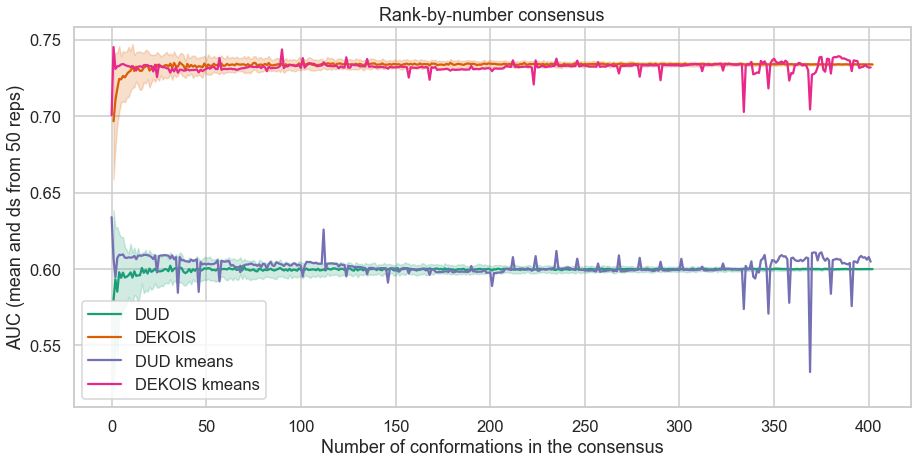

In [150]:
plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbn_DUD.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbn_DEKOIS.melt(), ci = 'sd', label = 'DEKOIS')

sns.lineplot(x = 'variable', y = 'value', 
             data = df_kmeans_rbn_DUD.T.melt(), label = 'DUD kmeans')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_kmeans_rbn_DEKOIS.T.melt(), label = 'DEKOIS kmeans')
plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Rank-by-number consensus')
plt.show()

### Best score
For each molecule $i$, get the lowest score of the $n$ scores calculated.
> $best\ score_i = min(s_i),$

where $s_i$ is an array of $n$ scores, belonging to the molecule $i$, in which each position $j$ corresponds to the docking score between the molecule $i$ and the protein conformation $j$.

In [70]:
def get_best_score(df):
    '''Get a dataframe of m*n values and returns a numpy array of best scores per row'''
    df_best = df.min(axis = 1)
    # (times -1 because roc_auc_score in the following line assumes higher is better)
    return df_best.to_numpy() * -1

#### Random Selection

In [88]:
%%time
f = get_best_score
N_REPS = 50
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1


file_cons_rbs_DUD = F'{output_dir}/\
RankByBestScore_random_sampling_1_to_402_features_CSAR_train_DUD_test.json'
if os.path.isfile(file_cons_rbs_DUD):
    df_cons_rbs_DUD = pd.read_json(file_cons_rbs_DUD)
else:
    df_X = X_dksc_DUD
    df_y = y_dksc_DUD

    df_cons_rbs_DUD = random_picking_consensus(f, df_X, df_y, 
                                MIN_CONFS, MAX_CONFS, INTERVAL, N_REPS)
    df_cons_rbs_DUD.to_json(file_cons_rbs_DUD)
    

file_cons_rbs_DEKOIS = F'{output_dir}/\
RankByBestScore_random_sampling_1_to_402_features_CSAR_train_DEKOIS_test.json'
if os.path.isfile(file_cons_rbs_DEKOIS):
    df_cons_rbs_DEKOIS = pd.read_json(file_cons_rbs_DEKOIS)
else:
    df_X = X_dksc_DEKOIS
    df_y = y_dksc_DEKOIS

    df_cons_rbs_DEKOIS = random_picking_consensus(f, df_X, df_y, 
                                MIN_CONFS, MAX_CONFS, INTERVAL, N_REPS)
    df_cons_rbs_DEKOIS.to_json(file_cons_rbs_DEKOIS)

CPU times: user 371 ms, sys: 3.74 ms, total: 374 ms
Wall time: 366 ms


#### k-means Selection

In [151]:
%%time
f = get_best_score
N_REPS = 50
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1


df_X = X_dksc_DUD
df_y = y_dksc_DUD

kmeans_rbs_DUD = kmeans_picking_consensus(f, df_X, df_y, MIN_CONFS, MAX_CONFS, INTERVAL, 
                             data_to_clust = mds_pisani_402[0], n_dims = 2,
                             random_state = 0, df_precomputed_medoids = df_confs_per_k)
df_kmeans_rbs_DUD = pd.DataFrame({'DUD': kmeans_rbs_DUD})



df_X = X_dksc_DEKOIS
df_y = y_dksc_DEKOIS

kmeans_rbs_DEKOIS = kmeans_picking_consensus(f, df_X, df_y, MIN_CONFS, MAX_CONFS, INTERVAL, 
                             data_to_clust = mds_pisani_402[0], n_dims = 2,
                             random_state = 0, df_precomputed_medoids = df_confs_per_k)
df_kmeans_rbs_DEKOIS = pd.DataFrame({'DEKOIS': kmeans_rbs_DEKOIS})

CPU times: user 3.95 s, sys: 428 ms, total: 4.38 s
Wall time: 4.38 s


#### Visualization

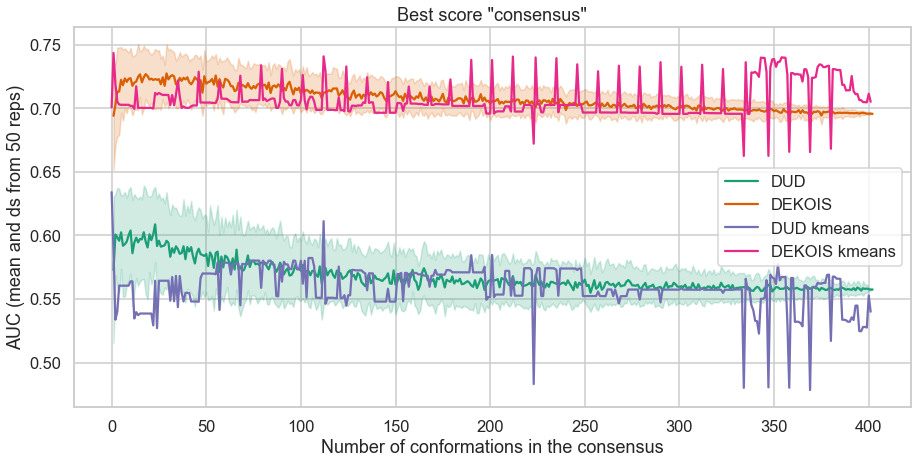

In [152]:

plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbs_DUD.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbs_DEKOIS.melt(), ci = 'sd', label = 'DEKOIS')

sns.lineplot(x = 'variable', y = 'value', 
             data = df_kmeans_rbs_DUD.T.melt(), label = 'DUD kmeans')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_kmeans_rbs_DEKOIS.T.melt(), label = 'DEKOIS kmeans')
plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Best score "consensus"')
plt.show()

### *Rank-by-rank*

For each conformation $j$ the $m$ molecules are ranked according to their docking score in that conformation, i.e.the molecule with the best score is assigned with the value 1, the second one with the best score is assigned with the value 2, and so on, until the molecule with the worst value is assigned with the value $m$. Finally, the average rank of each molecule is compute taking into account its rank in all the $n$ conformations.

> $R_bR_i = \frac{1}{n}\sum_jr^i_j,$

where $n$ is the number of protein conformations, and $r^i_j$ is the rank position of the molecule $i$ in the ranked score obtained in the protein conformation $j$.

In [78]:
def get_rank_by_rank(df):
    df_ranks = df.rank() # First, we get the ranking positions
    # For each ligand i we get the average score among the n conformations
    df_rank_by_rank = df_ranks.mean(axis = 1)
    return df_rank_by_rank.to_numpy() * -1

#### Random Selection

In [94]:
%%time
f = get_rank_by_rank
N_REPS = 50
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1

file_cons_rbr_DUD = F'{output_dir}/\
RankByRank_random_sampling_1_to_402_features_CSAR_train_DUD_test.json'
if os.path.isfile(file_cons_rbr_DUD):
    df_cons_rbr_DUD = pd.read_json(file_cons_rbr_DUD)
else:
    df_X = X_dksc_DUD
    df_y = y_dksc_DUD

    df_cons_rbr_DUD = random_picking_consensus(f, df_X, df_y, 
                                MIN_CONFS, MAX_CONFS, INTERVAL, N_REPS)
    df_cons_rbr_DUD.to_json(file_cons_rbr_DUD)

file_cons_rbr_DEKOIS = F'{output_dir}/\
RankByRank_random_sampling_1_to_402_features_CSAR_train_DEKOIS_test.json'
if os.path.isfile(file_cons_rbr_DEKOIS):
    df_cons_rbr_DEKOIS = pd.read_json(file_cons_rbr_DEKOIS)
else:
    df_X = X_dksc_DEKOIS
    df_y = y_dksc_DEKOIS

    df_cons_rbr_DEKOIS = random_picking_consensus(f, df_X, df_y, 
                                MIN_CONFS, MAX_CONFS, INTERVAL, N_REPS)
    df_cons_rbr_DEKOIS.to_json(file_cons_rbr_DEKOIS)

CPU times: user 366 ms, sys: 27.5 ms, total: 394 ms
Wall time: 379 ms


#### K-means Selection

In [153]:
%%time
f = get_rank_by_rank
N_REPS = 50
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1


df_X = X_dksc_DUD
df_y = y_dksc_DUD

kmeans_rbr_DUD = kmeans_picking_consensus(f, df_X, df_y, MIN_CONFS, MAX_CONFS, INTERVAL, 
                             data_to_clust = mds_pisani_402[0], n_dims = 2,
                             random_state = 0, df_precomputed_medoids = df_confs_per_k)
df_kmeans_rbr_DUD = pd.DataFrame({'DUD': kmeans_rbr_DUD})



df_X = X_dksc_DEKOIS
df_y = y_dksc_DEKOIS

kmeans_rbr_DEKOIS = kmeans_picking_consensus(f, df_X, df_y, MIN_CONFS, MAX_CONFS, INTERVAL, 
                             data_to_clust = mds_pisani_402[0], n_dims = 2,
                             random_state = 0, df_precomputed_medoids = df_confs_per_k)
df_kmeans_rbr_DEKOIS = pd.DataFrame({'DEKOIS': kmeans_rbr_DEKOIS})

CPU times: user 21.6 s, sys: 11.3 s, total: 32.9 s
Wall time: 32.9 s


#### Visualization

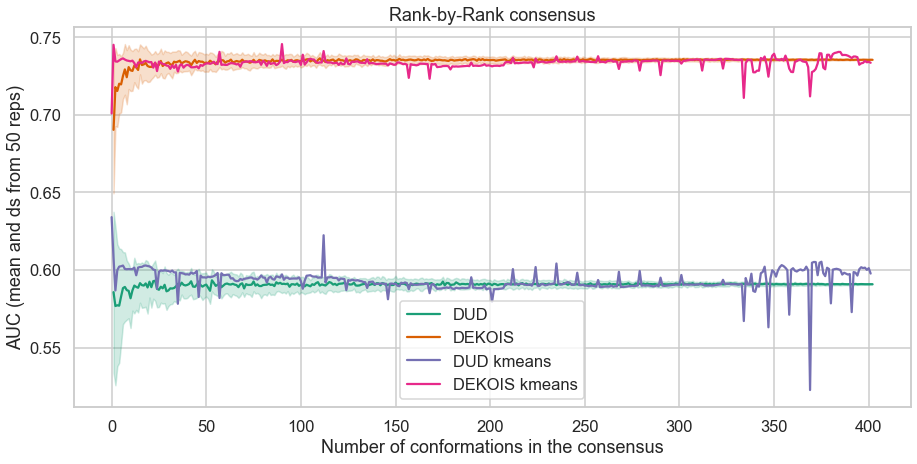

In [154]:

plt.figure(figsize=(15, 7))

sns.set_style("whitegrid")
sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbr_DUD.melt(), ci = 'sd', label = 'DUD')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_cons_rbr_DEKOIS.melt(), ci = 'sd', label = 'DEKOIS')

sns.lineplot(x = 'variable', y = 'value', 
             data = df_kmeans_rbr_DUD.T.melt(), label = 'DUD kmeans')
sns.lineplot(x = 'variable', y = 'value', 
             data = df_kmeans_rbr_DEKOIS.T.melt(), label = 'DEKOIS kmeans')
plt.xlabel('Number of conformations in the consensus')
plt.ylabel('AUC (mean and ds from 50 reps)')
plt.title('Rank-by-Rank consensus')
plt.show()

#### Rank-by-vote
Each molecule $i$ receives a vote if it ranked on top $x\%$ of the results in each conformation. The final score of the molecule is given by  the sum of vote obtained from all the protein conformations.